In [1]:
import pandas as pd 
import numpy as np 
import math 
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
!pwd

/home/erikkoppenhagen/Uni/graz/foundationsofcss/group_projekt/wikipedia-social-research-private/statistic_analysis


In [3]:
# Election details
elections = ['UK','USA','Germany','Austria']
election_times = {
    'UK':  ['2010-05-06', '2015-05-07', '2017-06-08', '2019-12-12', '2024-07-04'],
    'USA': ['2012-11-06', '2014-11-04', '2016-11-08', '2018-11-06', '2020-11-03','2024-11-03'],  
    'Germany':  ['2013-09-22', '2017-09-24', '2021-09-26'],
    'Austria':  ['2013-09-29', '2017-10-15', '2019-09-29', '2024-09-29']
}

files = {'UK':'../data/Final Datasets/Final Datasets/UK_politician_data.csv',
         #'USA-Represantatives':'../data/Final Datasets/Final Datasets/USA-Represantatives_rep_politician_data.csv',
         #'USA-Senat':'../data/Final Datasets/Final Datasets/USA-Senat_sen_politician_data.csv',
         'USA':'../data/Final Datasets/Final Datasets/USA_all_politician.csv',
         'Germany':'../data/Final Datasets/Final Datasets/Germany_politician_data.csv', 
         'Austria':'../data/Final Datasets/Final Datasets/Austria_politician_data.csv'}

In [4]:
datasets = {}
for file in files:
    data = pd.read_csv(files[file])
    data['Date'] = pd.to_datetime(data['Date'])
    datasets[file] = data.drop_duplicates()

In [3]:
## reading data
german = pd.read_csv('../data/Final Datasets/Final Datasets/Germany_politician_data.csv')
german['Date'] = pd.to_datetime(german['Date'])


In [5]:

def group_by_date(date, data, offset =3):
    """
    Gruppiert die Daten basierend auf einem Datum und einem ±3-Monats-Zeitraum.

    Args:
        date (str or pd.Timestamp): Referenzdatum.
        data (pd.DataFrame): DataFrame mit einer 'Date'-Spalte.

    Returns:
        tuple: Zwei DataFrames - innerhalb und außerhalb des Zeitraums.
    """
    
    date = pd.to_datetime(date)
    date_before = date - pd.DateOffset(months=offset)
    date_after = date #+ pd.DateOffset(months=offset)

    # Filtere die Daten
    values_in_date_range = data[(data['Date'] >= date_before) & (data['Date'] <= date_after)]
    values_outside_date_range = data[(data['Date'] < date_before) | (data['Date'] > date_after)]

    return values_in_date_range, values_outside_date_range

def filter_election_periods(data:pd.DataFrame,dates:list[str], offset:int = 3)->tuple[pd.DataFrame,pd.DataFrame]:
    data[(data['Date'] >= '2010-01-01') & (data['Date'] <= '2024-12-31')]
    election_data = pd.DataFrame()  
    not_election_data = data
    for date in dates:
        single_election_data, not_election_data = group_by_date(date, not_election_data, offset)
        election_data = pd.concat([election_data, single_election_data], ignore_index=True)
    return(election_data, not_election_data)




In [6]:
## test if data is nomal distibuted
## if p < 0.5 then data is NOT normaly distibuted
for election in datasets:
    print(f'####{election}######')
    print(stats.normaltest(datasets[election].Changes))

####UK######
NormaltestResult(statistic=714832.3692855317, pvalue=0.0)
####USA######
NormaltestResult(statistic=50657.0272018619, pvalue=0.0)
####Germany######
NormaltestResult(statistic=116691.30013803099, pvalue=0.0)
####Austria######
NormaltestResult(statistic=29719.77269916006, pvalue=0.0)


In [17]:
## does the mann whitneyu test becaus the data is not normaly distributed
for election in datasets:
    print(f'####{election}######')
    election_data, not_election_data = filter_election_periods(datasets[election],election_times[election],3)
    print(stats.mannwhitneyu(election_data.Changes, not_election_data.Changes, alternative='greater'))

####UK######
MannwhitneyuResult(statistic=24024572050.0, pvalue=1.0)
####USA######
MannwhitneyuResult(statistic=68395710.0, pvalue=0.9379305319282984)
####Germany######
MannwhitneyuResult(statistic=849847883.5, pvalue=0.9999916783421336)
####Austria######
MannwhitneyuResult(statistic=94499906.0, pvalue=0.4335742219024387)


In [23]:
## hypothesen test für verschiedene offsets

p_values_elections = {
    'UK':  [],
    'USA': [],
    'Germany':  [],
    'Austria':  []
}
for offset in range (10):
    for election in datasets:
        #print(f'####{election}######)
        election_data, not_election_data = filter_election_periods(datasets[election],election_times[election],offset)
        p_values_elections[election].append(stats.mannwhitneyu(x=election_data.Changes, y=not_election_data.Changes).pvalue)
        #print(stats.ttest_ind(a=election_data.Changes, b=not_election_data.Changes, equal_var=False))

    

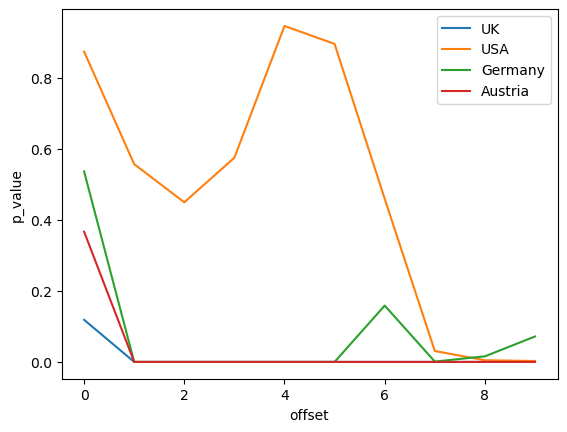

In [24]:
for election in p_values_elections:
    plt.plot(p_values_elections[election],label=election)
plt.xlabel('offset')
plt.ylabel('p_value')
plt.legend()

In [7]:
def group_by_person(election_data,not_election_data)->tuple[pd.Series,pd.Series]:
    # Berechne die Mittelwerte der Änderungen für jede Gruppe
    election_means = election_data.groupby('name')['Changes'].mean()
    not_election_means = not_election_data.groupby('name')['Changes'].mean()

    # Finde die gemeinsamen Namen in beiden DataFrames
    common_names = election_means.index.intersection(not_election_means.index)

    # Filtere die Daten auf die gemeinsamen Namen
    election_means_common = election_means.loc[common_names]
    not_election_means_common = not_election_means.loc[common_names]
    
    return (election_means_common, not_election_means_common)

In [16]:
## does a wilcoxon test weil abhänige stichproben
for election in datasets:
    print(f'####{election}######')
    election_data, not_election_data = filter_election_periods(datasets[election],election_times[election],3)
    election_data, not_election_data = group_by_person(election_data, not_election_data)
    print(stats.wilcoxon(x=election_data, y=not_election_data, alternative='greater'))
    

####UK######
WilcoxonResult(statistic=205197.0, pvalue=1.0)
####USA######
WilcoxonResult(statistic=41.0, pvalue=0.9556732177734375)
####Germany######
WilcoxonResult(statistic=113490.0, pvalue=0.999999981271898)
####Austria######
WilcoxonResult(statistic=18846.0, pvalue=0.999999465389015)


In [44]:
for election in datasets:
    print(f'####{election}######')
    election_data, not_election_data = filter_election_periods(datasets[election],election_times[election],3)
    print(stats.mannwhitneyu(election_data.Changes, not_election_data.Changes, alternative='two-sided'))

####UK######
MannwhitneyuResult(statistic=279030576276.5, pvalue=6.190182418265848e-20)
####USA-Represantatives######
MannwhitneyuResult(statistic=254195309910.0, pvalue=0.4931038856361426)
####USA-Senat######
MannwhitneyuResult(statistic=96857838118.5, pvalue=2.4482690831353547e-06)
####Germany######
MannwhitneyuResult(statistic=7161436566.0, pvalue=4.23310747596975e-32)
####Austria######
MannwhitneyuResult(statistic=404277358.5, pvalue=3.284243037880551e-27)


## testing

In [19]:
stats.ttest_ind(a=election_data.Changes, b=not_election_data.Changes, equal_var=False)

TtestResult(statistic=0.5478099509038079, pvalue=0.583822913722108, df=240429.81976911525)

In [31]:
german

,Date,Time,User,Size,Changes,Politician,name,link,Country,Party
0,2024-11-16,2024-11-16T15:43:16Z,InternetArchiveBot,9415,13,Christopher_Gohl,Christopher Gohl,/wiki/Christopher_Gohl,Germany,FDP
1,2024-10-13,2024-10-13T08:29:58Z,David Wintzer,9402,122,Christopher_Gohl,Christopher Gohl,/wiki/Christopher_Gohl,Germany,FDP
2,2024-10-13,2024-10-13T06:45:02Z,Dateientlinkerbot,9280,-64,Christopher_Gohl,Christopher Gohl,/wiki/Christopher_Gohl,Germany,FDP
3,2023-11-09,2023-11-09T17:04:24Z,Nico308,9344,49,Christopher_Gohl,Christopher Gohl,/wiki/Christopher_Gohl,Germany,FDP
4,2023-09-21,2023-09-21T15:13:43Z,Aka,9295,0,Christopher_Gohl,Christopher Gohl,/wiki/Christopher_Gohl,Germany,FDP
...,...,...,...,...,...,...,...,...,...,...
325610,2004-08-09,2004-08-09T09:50:39Z,Balû,431,137,Max_Straubinger,Max Straubinger,/wiki/Max_Straubinger,Germany,CSU
325611,2004-08-09,2004-08-09T09:50:39Z,Balû,431,137,Max_Straubinger,Max Straubinger,/wiki/Max_Straubinger,Germany,CSU
325612,2004-04-21,2004-04-21T18:19:50Z,Sansculotte,294,294,Max_Straubinger,Max Straubinger,/wiki/Max_Straubinger,Germany,CSU
325613,2004-04-21,2004-04-21T18:19:50Z,Sansculotte,294,294,Max_Straubinger,Max Straubinger,/wiki/Max_Straubinger,Germany,CSU


In [19]:
politician = german[german['Politician']=='Christopher_Gohl']
politician =politician.groupby('Date')['Changes'].mean()
#politician = politician.set_index('Date')

In [25]:
def fill_missing_date_for_politician(data: pd.DataFrame) -> pd.DataFrame:
    """
    Fills missing dates for each politician in the dataset with 0 changes.

    Args:
        data (pd.DataFrame): A DataFrame containing columns 'name', 'Date', and 'Changes'.

    Returns:
        pd.DataFrame: A DataFrame with all dates filled for each politician, and missing values replaced with 0.
    """
    # Generate a complete range of dates
    dates = pd.date_range(start='2010-01-01', end='2024-12-31', freq='D')  # Daily frequency

    # Initialize an empty list to store results
    merged_data = []
    i = 0
    # Process each politician's data
    for name in data['name'].unique():
        i = i + 1
        print(i,end='\r')
        # Filter data for the current politician
        politician_data = data[data['name'] == name]
        
        # Group by 'Date' and calculate the mean of 'Changes'
        politician_data = (
            politician_data.groupby('Date')['Changes']
            .mean()
            .reindex(dates, fill_value=0)  # Fill missing dates with 0
        )
        
        # Create a DataFrame with the complete date range
        df = pd.DataFrame({
            'Date': dates,
            'Changes': politician_data.values,
            'name': name
        })
        
        # Append to the result list
        merged_data.append(df)
    
    # Concatenate all dataframes into one
    merged_data = pd.concat(merged_data, ignore_index=True)
    return merged_data


In [26]:
for election in datasets:
    print(f'####{election}######')
    data = fill_missing_date_for_politician(datasets[election])
    election_data, not_election_data = filter_election_periods(data,election_times[election],3)
    election_data,not_election_data = group_by_person(election_data, not_election_data)
    print(stats.wilcoxon(election_data, not_election_data, alternative='two-sided'))

####UK######
WilcoxonResult(statistic=96725.0, pvalue=1.0169651751203742e-105)
####USA######
WilcoxonResult(statistic=64.0, pvalue=0.5790557861328125)
####Germany######
WilcoxonResult(statistic=64390.0, pvalue=9.918016506647014e-94)
####Austria######
WilcoxonResult(statistic=17336.0, pvalue=2.1938363167321793e-39)
